# Imports:

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [5]:
class MelDataset(Dataset):
    def __init__(self, csv_path, transform=None):
        self.df = pd.read_csv(csv_path)
        self.mel_paths = self.df["mel_npy_path"].tolist()
        self.transform = transform

    def __len__(self):
        return len(self.mel_paths)

    def __getitem__(self, idx):
        mel = np.load(self.mel_paths[idx])  # Shape: (n_mels, time)
        mel = (mel - mel.min()) / (mel.max() - mel.min()) # Normalize to [0, 1]
        mel = torch.tensor(mel, dtype=torch.float32).unsqueeze(0)  # (1, n_mels, time)
        if self.transform:
            mel = self.transform(mel)
        return mel

In [6]:
class ResidualConvBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels)
        )
        self.activation = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        return self.activation(x + self.block(x))

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_residual=True):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.residual = ResidualConvBlock(out_channels) if use_residual else nn.Identity()

    def forward(self, x):
        x = self.initial(x)
        return self.residual(x)


class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            nn.MaxPool2d(2)
        )
    
    def forward(self, x):
        return self.block(x)


class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.attn = SkipAttention(out_channels)
        self.conv = ConvBlock(out_channels * 2, out_channels)

    def forward(self, x, skip):
        x = self.up(x)
        if x.shape != skip.shape:
            x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=True)
        skip = self.attn(skip)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

class SkipAttention(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.attn = nn.Sequential(
            nn.Conv2d(channels, channels // 2, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // 2, channels, 1),
            nn.Sigmoid()
        )

    def forward(self, skip):
        return skip * self.attn(skip)



In [7]:
class MelEncoder(nn.Module):
    def __init__(self, embedding_dim=1024):
        super().__init__()
        self.initial_conv = ConvBlock(1, 32)
        self.down1 = DownBlock(32, 64)       # H/2, W/2
        self.down2 = DownBlock(64, 128)      # H/4, W/4
        self.down3 = DownBlock(128, 256)      # H/8, W/8
        self.down4 = DownBlock(256, 512)      # H/16, W/16
        self.final_block = nn.Sequential(
            nn.MaxPool2d(2),                  # H/32, W/32
            ConvBlock(512, embedding_dim)
        )

    def forward(self, x):
        skips = []
        x = self.initial_conv(x)   # -> [B, 32, H, W]
        skips.append(x)

        x = self.down1(x)          # -> [B, 64, H/2, W/2]
        skips.append(x)

        x = self.down2(x)          # -> [B, 128, H/4, W/4]
        skips.append(x)

        x = self.down3(x)          # -> [B, 256, H/8, W/8]
        skips.append(x)

        x = self.down4(x)          # -> [B, 512, H/16, W/16]
        skips.append(x)

        x = self.final_block(x)    # -> [B, 1024, H/32, W/32]
        return x, skips

In [8]:
class MelDecoder(nn.Module):
    def __init__(self, embedding_dim=1024):
        super().__init__()
        self.up1 = UpBlock(embedding_dim, 512)       # H/16
        self.up2 = UpBlock(512, 256)                 # H/8
        self.up3 = UpBlock(256, 128)                 # H/4
        self.up4 = UpBlock(128, 64)                  # H/2
        self.up5 = UpBlock(64, 32)                   # H
        self.final_conv = nn.Sequential(
            nn.Conv2d(32, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, z, skips):
        x = self.up1(z, skips[4])        # -> [B, 512, H/16, W/16]
        x = self.up2(x, skips[3])        # -> [B, 256, H/8, W/8]
        x = self.up3(x, skips[2])        # -> [B, 128, H/4, W/4]
        x = self.up4(x, skips[1])        # -> [B, 64, H/2, W/2]
        x = self.up5(x, skips[0])        # -> [B, 32, H, W]
        return self.final_conv(x)

In [9]:
class MelAutoencoder(nn.Module):
    def __init__(self, encoder, decoder, embedding_dim=1024):
        super().__init__()
        self.encoder = MelEncoder(embedding_dim)
        self.decoder = MelDecoder(embedding_dim)

    def forward(self, x):
        z, skips = self.encoder(x)
        return self.decoder(z, skips)


In [10]:
def train_auto_encoder(model, train_loader, val_loader, epochs=200, checkpoint_dir='checkpoints/reference_encoder'):
    model.to(device)
    optimizer = optim.Adam(
        list(model.parameters()),
        lr=1e-3, weight_decay=1e-4  # L2 regularization term
    )

    os.makedirs(checkpoint_dir, exist_ok=True)

    for epoch in range(1, epochs + 1):
        # ----- Training -----
        model.train()
        train_loss = 0
        for mel in train_loader:
            mel = mel.to(device)  # [B, 1, M, T]
            recon = model(mel)
            loss = F.l1_loss(recon, mel) + 0.1 * F.mse_loss(recon, mel)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        # ----- Validation -----
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for mel in val_loader:
                mel = mel.to(device)
                recon = model(mel)
                loss = F.l1_loss(recon, mel)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch {epoch}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

        # ----- Save checkpoint -----
        if epoch % 5 == 0:
            checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch}.pth')
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Checkpoint saved to {checkpoint_path}")


In [11]:
train_df = pd.read_csv("Data/split_train_val/train_split.csv")
val_df = pd.read_csv("Data/split_train_val/val_split.csv")

train_df["mel_npy_path"] = train_df["mel_npy_path"].apply(lambda x: x.replace("\\", "/"))
val_df["mel_npy_path"] = val_df["mel_npy_path"].apply(lambda x: x.replace("\\", "/"))

train_dataset = MelDataset(csv_path="Data/split_train_val/train_split.csv")
val_dataset = MelDataset(csv_path="Data/split_train_val/val_split.csv")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

encoder = MelEncoder(embedding_dim=512).to(device)
decoder = MelDecoder(embedding_dim=512).to(device)
autoencoder = MelAutoencoder(encoder=encoder, decoder=decoder).to(device)

# train_auto_encoder(autoencoder, train_loader, val_loader, epochs=200)

cuda


In [23]:
def visualize_first_10(autoencoder, dataloader, device, checkpoint_path = 'checkpoints/reference_encoder/checkpoint_epoch_35.pth'):
    autoencoder.load_state_dict(torch.load(checkpoint_path, map_location=device))
    autoencoder.eval()

    with torch.no_grad():
        for batch in dataloader:
            original = batch.to(device)
            reconstructed = autoencoder(original)
            break  # Only take the first batch

    original = original.cpu()
    reconstructed = reconstructed.cpu()

    # Plot the first 10 samples
    for i in range(10):
        plt.figure(figsize=(10, 3))

        # Original
        plt.subplot(1, 2, 1)
        plt.imshow(original[i][0], aspect='auto', origin='lower', cmap='magma')
        plt.title(f'Original #{i+1}')
        plt.colorbar()

        # Reconstructed
        plt.subplot(1, 2, 2)
        plt.imshow(reconstructed[i][0], aspect='auto', origin='lower', cmap='magma')
        plt.title(f'Reconstructed #{i+1}')
        plt.colorbar()

        plt.tight_layout()
        plt.show()


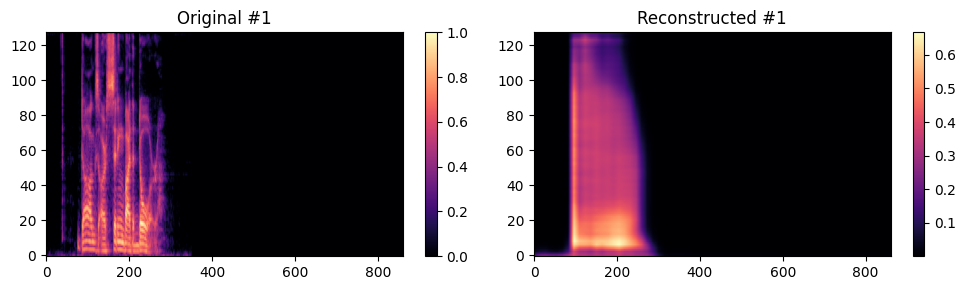

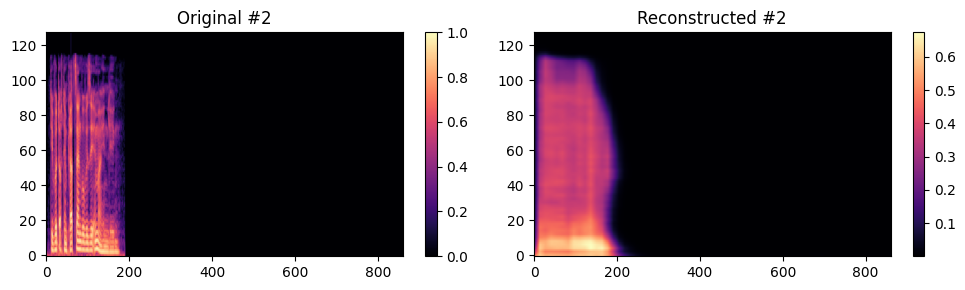

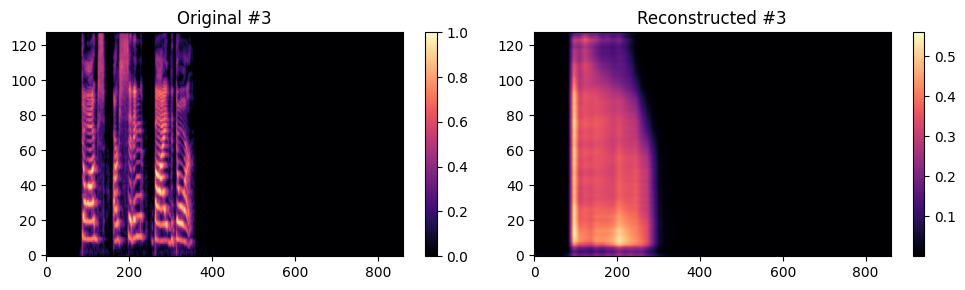

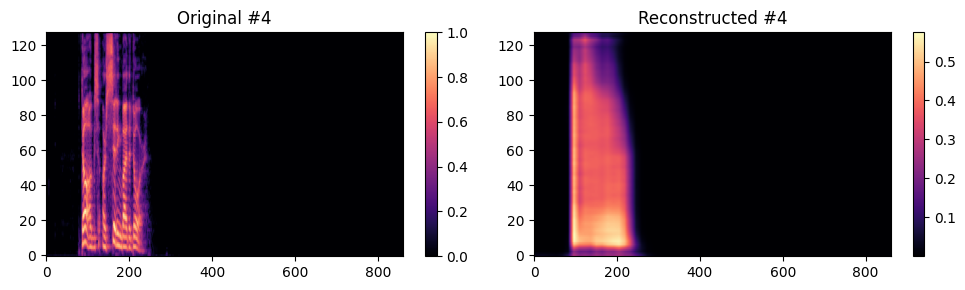

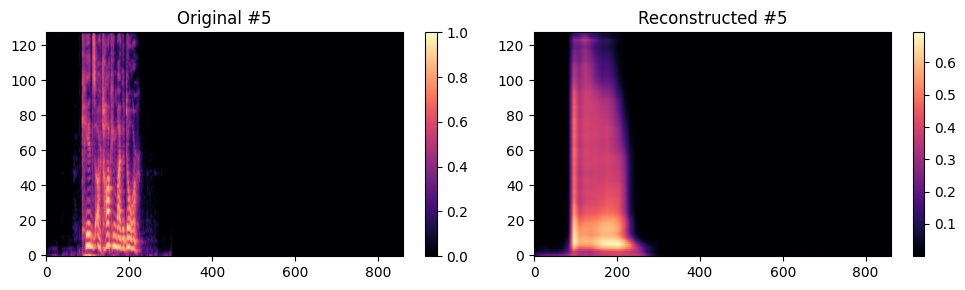

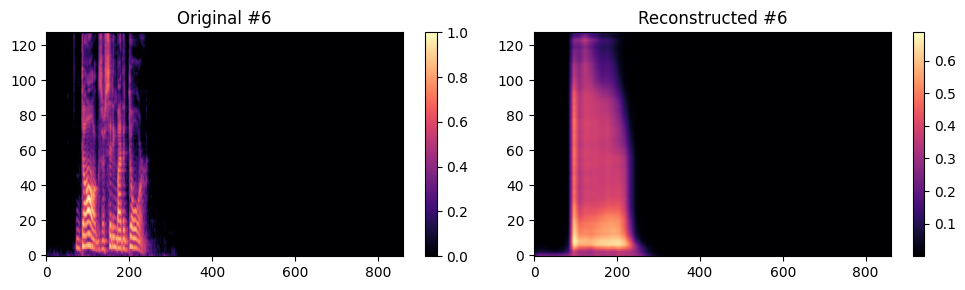

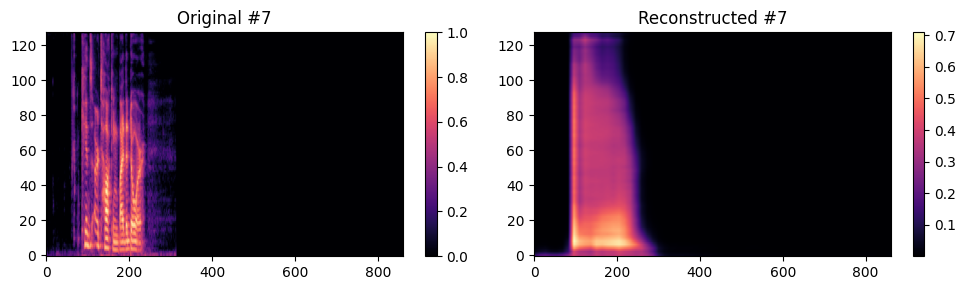

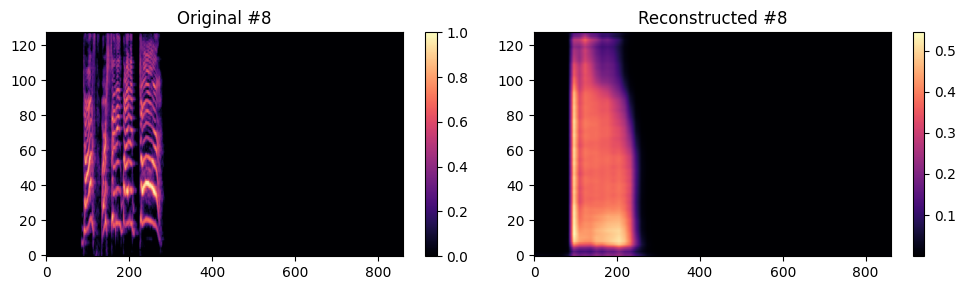

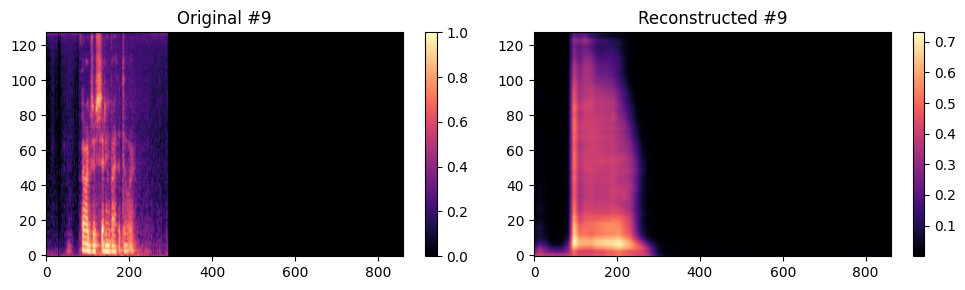

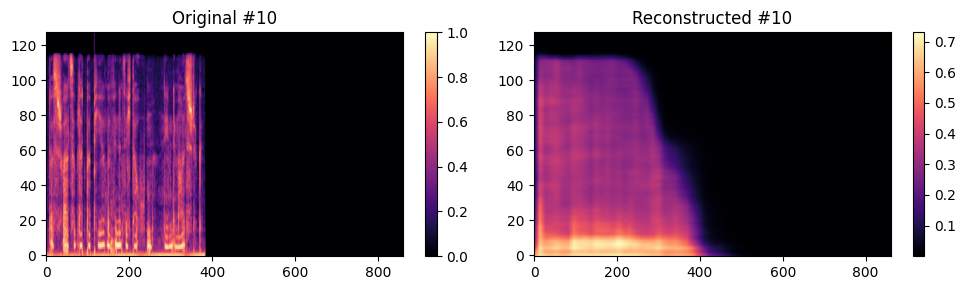

In [24]:
visualize_first_10(autoencoder, val_loader, device)


In [15]:
def visualize_first_10_auto(autoencoder, dataloader, device, checkpoint_path = 'checkpoints/auto-encoder/checkpoint_epoch_20.pth'):
    autoencoder.load_state_dict(torch.load(checkpoint_path, map_location=device))
    autoencoder.eval()

    with torch.no_grad():
        for batch in dataloader:
            original = batch.to(device)
            reconstructed = autoencoder(original)
            break  # Only take the first batch

    original = original.cpu()
    reconstructed = reconstructed.cpu()

    # Plot the first 10 samples
    for i in range(10):
        plt.figure(figsize=(10, 3))

        # Original
        plt.subplot(1, 2, 1)
        plt.imshow(original[i][0], aspect='auto', origin='lower', cmap='magma')
        plt.title(f'Original #{i+1}')
        plt.colorbar()

        # Reconstructed
        plt.subplot(1, 2, 2)
        plt.imshow(reconstructed[i][0], aspect='auto', origin='lower', cmap='magma')
        plt.title(f'Reconstructed #{i+1}')
        plt.colorbar()

        plt.tight_layout()
        plt.show()


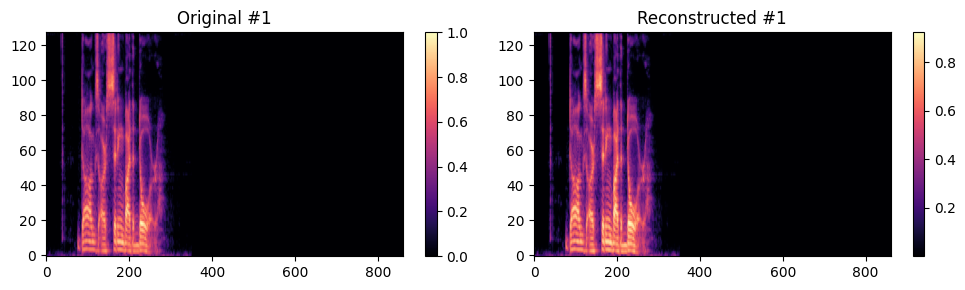

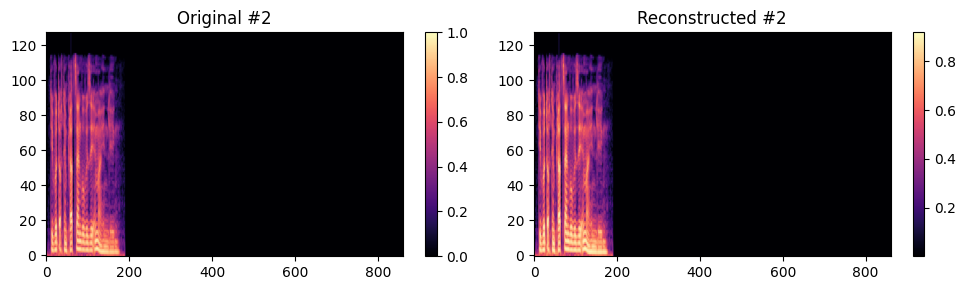

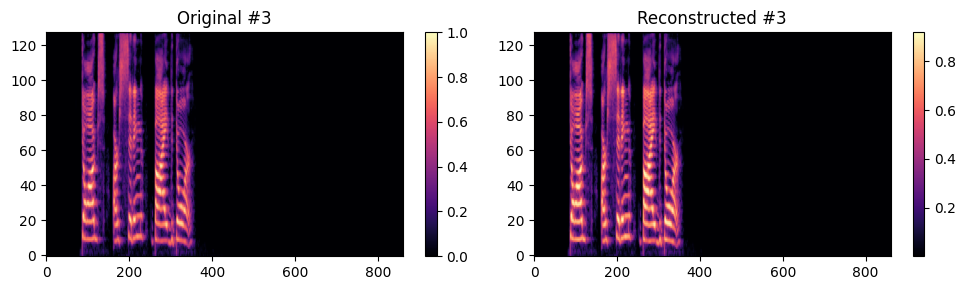

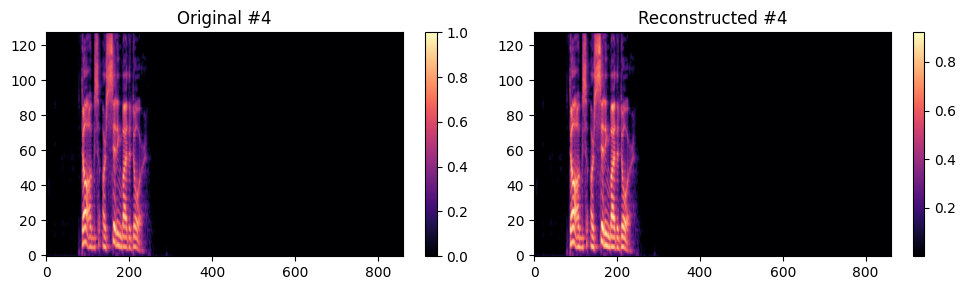

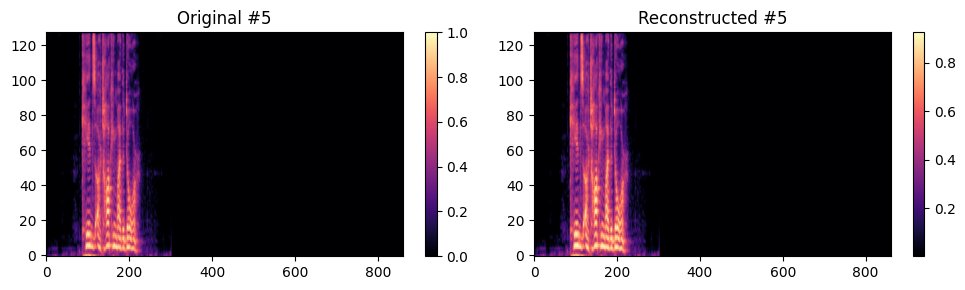

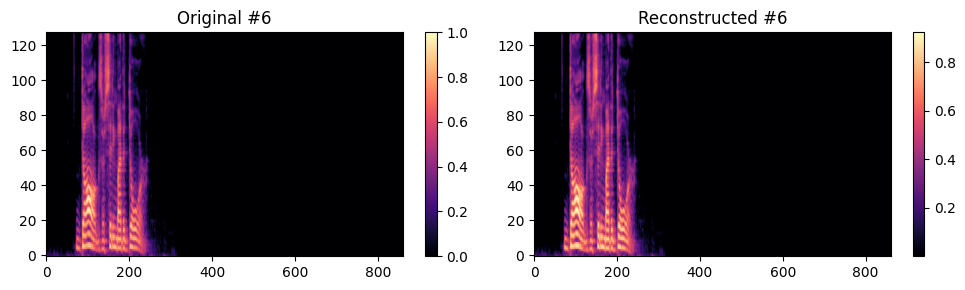

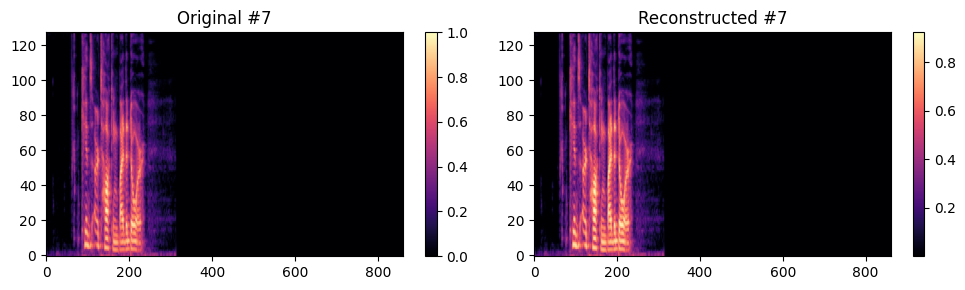

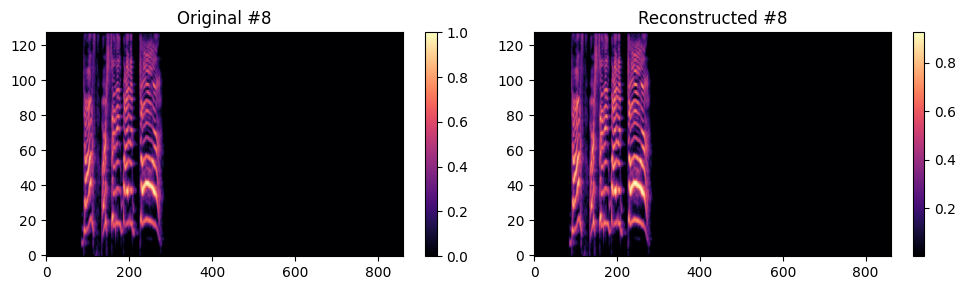

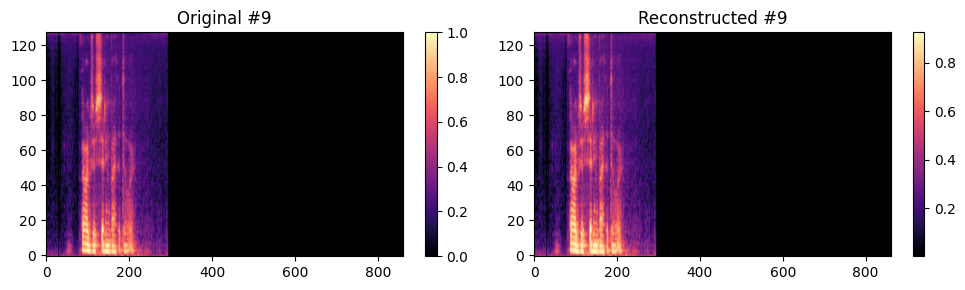

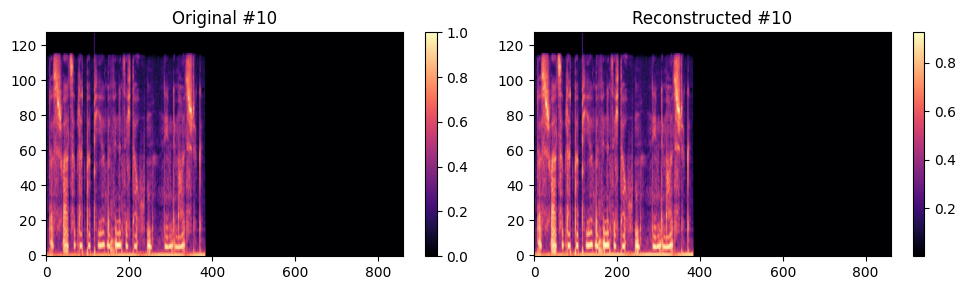

In [16]:
visualize_first_10_auto(autoencoder, val_loader, device)